In [23]:
import math
import numpy as np
import time
from typing import NamedTuple, List, Tuple

ALPHA = 0.6

class Experience(NamedTuple):
    state: np.ndarray       # what was the state @ time T
    action: int             # action that was taken in S @ time T
    reward: float           # immediate reward
    next_state: np.ndarray  # next state
    done: bool              # has the episode finished

class PrioritizeExperience:
    def __init__(self, state : np.ndarray, action : int, reward: float, next_state: np.ndarray, done: bool, td_error: float):
        self.state = state          # what was the state @ time T
        self.action = action        # action that was taken in S @ time T
        self.reward = reward        # immediate reward
        self.next_state = next_state  # next state
        self.done = done            # has the episode finished
        self.td_error = td_error    # this is required for replay buffer's weighted computation

    @property
    def priority(self):
        # PrioritizedReplay research paper says "the transition with the absolute largest TD error.." so 
        # we take the absolute value here
        assert math.isinf(self.td_error) == False

        p_abs = abs(self.td_error)
        if p_abs == 0:
            return 0    # an experience with 0 priority is not required to be sampled so we dont do a p_abs ** 0 on it
        else:
            return p_abs ** ALPHA

## SumTree

A binary tree based datastructure that can be used to pick experiences at random where the chance of an experience to be picked randomly is determined by how high the td_error of that experience is.

An array based implementation of the SumTree follows. Leaf nodes are kept separately but the memory (list) is passed to SumTree. Each leaf node has a priority (which is the td_error). Non-leaf nodes are the sum of its children. So the root of the tree contains the overall sum of all priorities.

To choose an experience randomly, a uniform random number is generated between 0 and the sum of priorities (the root node). To look for the experience that corresponds to this random number, the tree is traversed. If r is smaller then the node, left child is traversed, otherwise left child's value is subtracted from r and the right side is traversed.

In [24]:
class FindResult(NamedTuple):
    index : int
    experience : PrioritizeExperience

class SumTree:
    """
    Picks an experience randomly, but the chance of an experience to be picked up is based on how high is the
    priority of that experience. For priority, the td_error is used.
    """
    def __init__(self, leaf_nodes : List[PrioritizeExperience], max_size = None):
        """
        leaf_nodes: this is the list where experience is being stored. SumTree uses
            the same memory location for accessing the leaf_nodes' td_error
        """
        size = max_size if max_size != None else len(leaf_nodes)
        self.leaf_nodes = leaf_nodes
        
        # the last layer of a binary tree has 2^h + 1 nodes, where h is the height of the
        # tree. We use the inverse function to find out the number of nodes
        self.nonleaf_count = 2 ** math.ceil(np.log2(size))
        self.nodes = np.zeros(shape = self.nonleaf_count)
        
        # although we don't keep the leaf nodes with us but to find out the parent
        # we need to know where the non-leaf nodes would have been kept in the tree
        self.leaf_start = self.nonleaf_count
        #print(f'non-leaf size: {self.nonleaf_count}, self.leaf_start {self.leaf_start}')

    @property
    def root(self) -> float:
        return self.nodes[1]
    
    def __len__(self):
        return len(self.leaf_nodes)
    
    def add(self, index : int):
        #self.nodes[index] = item_priority
        #self.leaf_index = (self.leaf_index + 1) % self.size

        # had we kept the leaf_nodes here, the index would have been
        # after self.leaf_start_index
        #print(f'Index added: {index}')
        
        # Since we don't have the leaf nodes with us, we need to figureout which 
        # two nodes make the left and right. So 0,1 make a pair, 2, 3 make another
        # So whatever index the new leaf was stored at, the left will be even and 
        # right would be the odd number
        left_index = index & 0xFFFFFFFE
        right_index = index | 1
        
        left_p = self.leaf_nodes[left_index].priority if self.leaf_nodes[left_index] != None else 0
        right_p = self.leaf_nodes[right_index].priority if self.leaf_nodes[right_index] != None else 0
        
        leaf_sum = left_p + right_p
        
        #print(f'index: {index}, left: {left_index}, right:{right_index}, leaf_sum: {leaf_sum}')

              
        # figure out where the leaf node would have been kept
        leaf_index = index + self.leaf_start
        parent = leaf_index // 2
        self.nodes[parent] = leaf_sum
              
        #print(f'First parent: {parent} for index: {index}')

        parent //= 2
        while parent > 0:
            self.nodes[parent] = self.nodes[parent * 2] + self.nodes[parent * 2 + 1]
            #print(f'Next parent: {parent} = {self.nodes[parent]}')
            parent //= 2

    
    def find(self, random_priority : float) -> FindResult:
        assert random_priority <= self.root, f'Random priority: {random_priority} exceds root {self.root}'
        
        # root is at 1st element of the array not the 0th
        index = 1
        p = random_priority

        # start from the root and go till the start of leaf nodes, then choose
        # the index of the leaf node that covers the priority given
        while index * 2 < self.leaf_start:
            left_index = index * 2
            right_index = index * 2 + 1
            
            left_value = self.nodes[left_index]
            if p < left_value:
                index = left_index
            else:
                p -= left_value
                index = right_index


        assert left_index & 1 == 0      # left index has to be even numbered
        assert right_index & 1 == 1     # right index has to be odd numbered
         
        # The leaf node's priority has to be considered as well in deciding
        # which of the two children covers the given p
        left_index = (index * 2) - self.leaf_start
        right_index = left_index + 1
        
        #print(f'left: {left_index}, right: {right_index}, priority: {priority}')
              
        left_value = self.leaf_nodes[left_index].priority
        if p < left_value:
            index = left_index
        else:
            index = right_index
    
        return FindResult(index, self.leaf_nodes[index])
    
    def pick_random(self) -> FindResult:
        return self.find(np.random.uniform(0, self.root))


## Test Case

Add about 10 random experiences in the SumTree and confirm that the root node has the same total td_error as the total computed iteratively

In [25]:
memory = [None] * 10
st = SumTree(memory)

# Generate an experience and sum up the td_error
total_weight = 0
for i in range(len(memory)):
    memory[i] = PrioritizeExperience(
            np.random.uniform(0, 37), 
            np.random.uniform(0, 4), 
            np.random.rand(), 
            np.random.uniform(0, 37), 
            False, 
            np.random.rand())
    st.add(i)
    total_weight += memory[i].priority
    
    if (i + 1) % 1000 == 0:
        print(f'\r{i}', end = '')
        
print('\r')
print(f'Root: {st.root}')
print(f'Total computed: {total_weight}')

assert abs(st.root - total_weight) < 0.001, f'Ops! st says root: {st.root} and loop says {total_weight}'

print('Yes! the sumtree root and the total weight match')


Root: 5.871921153122539
Total computed: 5.871921153122539
Yes! the sumtree root and the total weight match


## Test SumTree On 100_000 Picks

Each value has a priority and if we query the sumtree to give us a value randomly between 0 and the total sum, then the number of times an index is returned would be the same as its weightage in the priorities. A higher priority would result in a higher number of times that number is returned to us

Weightage computed
Iterative Weigtage: [0.12705392 0.03538327 0.03538327 0.12829053 0.12226608 0.03583884
 0.12226608 0.12190536 0.03538327 0.0656517 ]
Sum Tree Weightage: [0.12705392 0.03538327 0.03538327 0.12829053 0.12226608 0.03583884
 0.12226608 0.12190536 0.03538327 0.0656517 ]
How many weights differ: [ 0.00140884 -0.00109608]


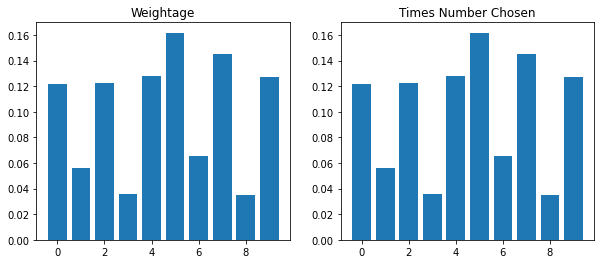

In [27]:
import matplotlib.pyplot as plt

weightage = [x.priority / total_weight for x in memory]

count = 100_000
index_count = [0] * len(memory)

for i in range(count):
    index, _ = st.pick_random()
    index_count[index] += 1
    
    if (i + 1) % 1000 == 0:
        print(f'\r{i+1}', end ='')

weightage_st = [x / count for x in index_count]    
print('\rWeightage computed')

a = np.array(weightage)
b = np.array(weightage_st)

print_index = np.random.randint(len(memory), size=10)
print(f'Iterative Weigtage: {a[print_index]}')
print(f'Sum Tree Weightage: {a[print_index]}')

diff = a - b
print(f'How many weights differ: {diff[np.fabs(diff) > 0.001]}')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.bar(range(len(memory)), a)
ax1.title.set_text('Weightage')

ax2.bar(range(len(memory)), a)
ax2.title.set_text('Times Number Chosen')

plt.show()


In [30]:
import torch.nn as nn

model = nn.Sequential(nn.Linear(37, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 4))

print(model)

Sequential(
  (0): Linear(in_features=37, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)
